# Aula 2 - Modelos de IA & ML

##Exercício de fixação V /desafio III - Árvore de Decisão

In [0]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [0]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas. 
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas:

In [3]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Descrição de nossas variáveis:

Survived - Sobreviveu? (0 = Não; 1 = Sim);
Pclass - Classe do ticket do passageiro (1 = Primeira; 2 = Segunda; 3 = Terceira);
Name - Nome;
Sex - Sexo;
Age - Idade;
SibSp - Número de irmãos/irmãs/esposo/esposa a bordo;
Parch - Número de pais/filhos a bordo;
Ticket - Número do ticket;
Fare - Custo do ticket para o passageiro (em pounds);
Cabin - Cabine;
Embarked - Porto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton);

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.

Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn:

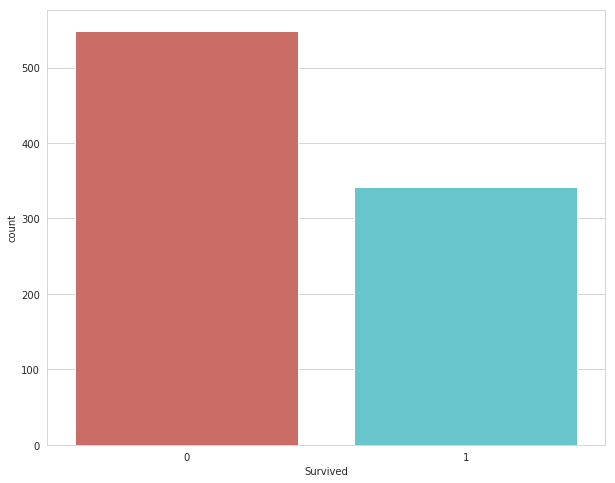

In [4]:
sb.countplot(x='Survived',data=titanic, palette='hls')

Ok, agora veja que a variavel Survived é binária.

# Checando por valores faltantes

É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variaveis:

In [5]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por valores faltantes; então podemos eliminar essa variável completamente! Mas e quanto à idade? 

A idade parece ser um preditor relevante para a sobrevivência, certo? 

Nós queremos manter as variáveis, entretanto possuímos 177 valores faltante. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

# Lidando com valores faltantes

Removendo valores faltantes:

Nesse caso em particular acabmos descartando todas as variáveis que não são relevantes para a predição de sobrevivência:

In [7]:
#E quanto ao nome de uma pessoa, número do bilhete e número de identificação do passageiro? Eles são irrelavantes para prever a capacidade de sobrevivência. E, como você se lembra, a variável cabine é quase todo composta por valores faltantes!
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


O dataframe foi então reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável idade.

# Imputando valores faltantes

Primeiro vejamos como a idade do passageiro está relacionada à sua classe como passageiro no navio:

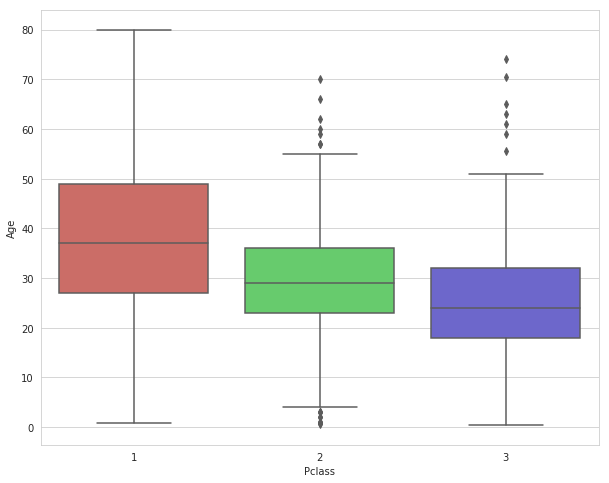

In [8]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

A partir do exposto, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe e, quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. 

Portanto, há um certo relacionamento, ainda que fraco, entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na análise via boxplot, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, já para os passageiros de 2ª classe é 29 e para os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Idade (Age) e, para cada nulo, verifique o valor da Pclass (Classe do Passageiro) e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [0]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Após definir a função, vamos executar apenas para os valores nulos de Idade (Age):

In [0]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)

In [11]:
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked (onde embarcou). 

Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso:

In [12]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# Convertendo variáveis categóricoas em indicadores dummy:

In [13]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [14]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [15]:
#Ainda não alteramos os dados! Vamos alterar logo em seguida.

titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [16]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [17]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


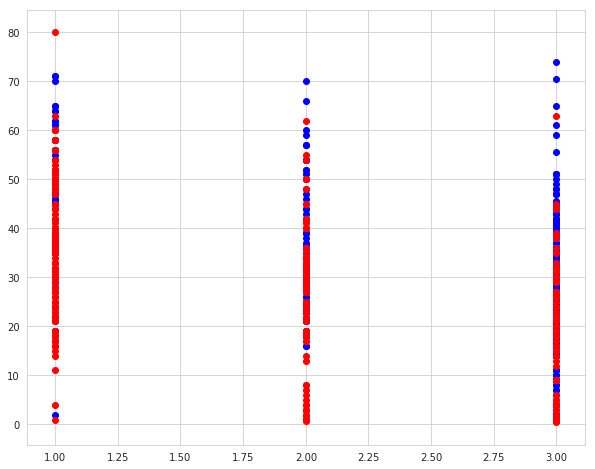

In [18]:
plt.scatter(x=titanic_dmy.loc[titanic_dmy.Survived==0, 'Pclass'],
            y=titanic_dmy.loc[titanic_dmy.Survived==0, 'Age'], c='blue')
plt.scatter(x=titanic_dmy.loc[titanic_dmy.Survived==1, 'Pclass'], 
            y=titanic_dmy.loc[titanic_dmy.Survived==1, 'Age'], c='red')

Agora temos um conjunto de dados com todas as variáveis no formato correto!

# Validando a independencia entre as variáveis

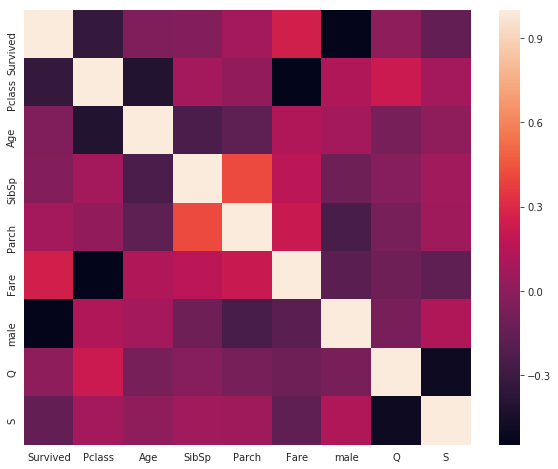

In [19]:
sb.heatmap(titanic_dmy.corr())  

Fare e Pclass não sao independentes uma com a outra, entao no exemplo dado em sala acabei por excluí-las. Será que poderíamos fazer de outro modo?

In [20]:
titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,0,35.0,0,0,8.0500,1,0,1


# Agora vamos fazer a criaçao de nosso modelo, passo a passo!

1º: Separamos o conjunto em variável resposta e variáveis de treinamento:

In [0]:
X = titanic_dmy.iloc[:,[1,2,3,4,5,6,7]].values
y = titanic_dmy.iloc[:,0].values

Agora dividimos em sets de treinamento e teste (teste com 30% - Pode-se usar também 80/20, a famosa Regra de Pareto - Referência para conhecimento de todos: https://www.youtube.com/watch?v=amxPk01g37M)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

# Criando nosso modelo

In [23]:
Classif_tree = DecisionTreeClassifier()
Classif_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Testando nosso modelo

In [0]:
y_pred = Classif_tree.predict(X_test)

# Avaliando nosso modelo

Analisamos então o rótulo real para com o rótulo predito:

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix


array([[130,  34],
       [ 28,  75]])

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       164
           1       0.69      0.73      0.71       103

    accuracy                           0.77       267
   macro avg       0.76      0.76      0.76       267
weighted avg       0.77      0.77      0.77       267



In [27]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.7677902621722846


Na próxima aula teremos um review a respeito de métricas para a correta leitura dos resultados de nosso algoritmos.

[Desafio 3] Como terceiro desafio, tentem melhorar nosso valor de acurácia atual (76%). 

Para tanto, podem consultar outros kernels abertos como referência:
  
https://www.kaggle.com/c/titanic/notebooks
 
Se conseguirem boas soluções sugiro se registrarem no Kaggle e postarem suas descobertas, é uma ótima maneira de pôr seus skills a prova junto a uma comunidade mundial crescente.
  